# MCMC - Importance sampling

Implementation of the equations found in [Importance Sampling](https://www.youtube.com/watch?v=TNZk8lo4e-Q&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=20)

\begin{align*}
p( \mathbf y | \mathbf X, \mathbf\theta) &= \Pi_i \mathrm {Ber} (y_i | \mathrm {sigm} (x_i, \mathbf \theta) ) \\
         &= \Pi_i \Big[ \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{y_i} \Big[ 1 - \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{1 - y_i}
\end{align*}



Also, we assume a Gaussian prior ...

\begin{align*}
p(\theta) = \frac {1} {\sqrt {2 \pi \sigma ^2}} \exp \Big(-\frac 1 {2\sigma^2} (\theta-\mu)'(\theta-\mu) \Big)
\end{align*}

Then, we shall be able to find the posterior using:

\begin{align*}
p(\theta | \mathbf X, \mathbf y) = \frac 1 Z p(\mathbf y | \mathbf X, \theta) p(\theta)
\end{align*}

Note that we are trying to maximize this function (or alternatively minimizing the $-\log$ of this function). Taking the negative log of this function, we get ...

\begin{align*}
J(\theta) = -log(p(\theta| \mathbf X, \mathbf y)) &= \mathrm {const} - \log p(\mathbf y| \mathbf X, \theta) - \log p (\theta) \\
 &= \mathrm {const} - \Sigma_i [ y_i \log{\pi_i} + (1-y_i)\log( 1 - \pi_i ) ]  \frac 1 {2 \sigma ^2} || \theta ||_2 ^2
\end{align*}

In the case wherein we want a single value of $\theta$, we shall be doing gradient decent. However, we dont want to find a single value of theta, bur rather a meaningful distribution of theta. For that, we need to use some form of numerical technique. This is what we are going to do next.

Note that the calculation of $Z$ is unknown and hard. Also note that $Z$ is independent of $\theta$

\begin{align*}
Z &= \int p(\mathbf y|\mathbf X, \theta) p(\theta) d\theta \\
  &= \int \frac {p(\mathbf y|\mathbf X, \theta) p(\theta)} {q(\theta)} q(\theta)  d\theta \\
  &= \int {w(\theta)} q(\theta)  d\theta
\end{align*}

Here, $q(\theta)$ is something that you can choose. For example, you can use $q(\theta) = \mathcal N(0, 1000 )$

## Importance sampling

Here, we shall convert the operation into a summation operation:

\begin{align*}
 z &= \int w(\theta) q(\theta) d\theta \\
   &= \frac 1 N \Sigma_i w( \theta_i )
\end{align*}

Note here that we will be drawing samples form $q(\theta)$


## Doing this with some data ...

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plotGaussian(mu, sigma, N=6, ax=None, *args, **kwargs):
    
    x = np.linspace(mu-N*sigma, mu+N*sigma, 1000)
    y = (1/np.sqrt( 2 * np.pi *sigma**2 ))*np.exp( - (x-mu)**2/(2*sigma**2) )
    
    if ax is None:
        plt.plot(x, y, *args, **kwargs)
    else:
        ax.plot(x, y, *args, **kwargs)
    
    return

def generateData(tRealMu, tRealSig, Ndata=100, Nsample=40):
    
    tRealMu_1 = tRealMu.flatten()
    X = 20*np.random.rand(Ndata, len(tRealMu_1)) - 10
    theta = np.random.multivariate_normal( tRealMu, tRealSig, size=Nsample )
    y = (X @ theta.T).flatten()
    pi_i = 1/(1 + np.exp( -y ))
    
    X = np.vstack([X for i in range(Nsample)])
    
    return X, y, theta

In [192]:
tRealMu = np.array([5,-7]).reshape((-1, 1))
tRealSig = np.array([
    [2, 0],
    [0, 3] ])

In [138]:
X, y, theta = generateData(tRealMu, tRealSig, Ndata=1000, Nsample=1)

In [197]:
def plotProb(probFunc, xLim=[-10, 10], yLim=[-10, 10], Nsample=1000, cmapName='Blues', *args, **kwargs):
    
    cmap = cm.get_cmap(cmapName)
    x = np.random.uniform(xLim[0], xLim[1], (Nsample, 1))
    y = np.random.uniform(yLim[0], yLim[1], (Nsample, 1))
    data = np.hstack( (x, y) )
    prob = probFunc(data, *args, **kwargs)
    color = cmap(prob / prob.max())
    
    plt.figure()
    plt.scatter(x.flatten(), y.flatten(), c=color)
    plt.axis('equal')
    plt.show()
    plt.close('all')
    
    return

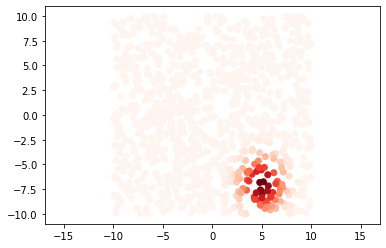

In [200]:
def probFunc(data, mu, sigma):
    
    xs = (data - mu.T)
    k=2
    sigmaInv = np.linalg.inv(sigma)
    sigmaDet = np.linalg.det(sigma)
    
    #print(data.shape, mu.shape, x.shape, sigmaInv.shape, x.T.shape)
    ps = []
    for x in xs:
        x1 = x.copy()
        x1 = x1.reshape((-1, 1))
        p = np.exp(-0.5 * (x1.T @ sigmaInv @ x1))
        p = p / np.sqrt((2*np.pi)**k * sigmaDet )
        ps.append(p.flatten()[0])
    
    return np.array(ps)

plotProb(probFunc, Nsample=1000, cmapName = 'Reds', mu=tRealMu, sigma=tRealSig)

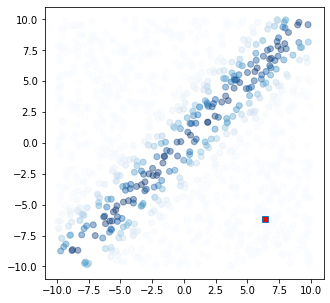

In [156]:

test = cm.get_cmap('Blues')

colors = test(np.exp(-y**2/(2*10**2)))
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1],  c=colors, alpha=0.4)
plt.plot(theta[:, 0], theta[:, 1], 's', mfc='red')
plt.show()
plt.close('all')